In [1]:
import numpy as np
import pandas as pd
import sklearn as skl
from matplotlib import pyplot as plt
from sklearn.model_selection import StratifiedKFold
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import average_precision_score

The dataset contains transactions made by credit cards in September 2013 by European cardholders.
This dataset presents transactions that occurred in two days, where we have 492 frauds out of 284,807 transactions. The dataset is highly unbalanced, the positive class (frauds) account for 0.172% of all transactions.

It contains only numerical input variables which are the result of a PCA transformation. Unfortunately, due to confidentiality issues, we cannot provide the original features and more background information about the data. Features V1, V2, … V28 are the principal components obtained with PCA, the only features which have not been transformed with PCA are 'Time' and 'Amount'. Feature 'Time' contains the seconds elapsed between each transaction and the first transaction in the dataset. The feature 'Amount' is the transaction Amount, this feature can be used for example-dependant cost-sensitive learning. Feature 'Class' is the response variable and it takes value 1 in case of fraud and 0 otherwise. 

In [2]:
Data = pd.read_csv("creditcard.csv")
Data

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
284802,172786.0,-11.881118,10.071785,-9.834783,-2.066656,-5.364473,-2.606837,-4.918215,7.305334,1.914428,...,0.213454,0.111864,1.014480,-0.509348,1.436807,0.250034,0.943651,0.823731,0.77,0
284803,172787.0,-0.732789,-0.055080,2.035030,-0.738589,0.868229,1.058415,0.024330,0.294869,0.584800,...,0.214205,0.924384,0.012463,-1.016226,-0.606624,-0.395255,0.068472,-0.053527,24.79,0
284804,172788.0,1.919565,-0.301254,-3.249640,-0.557828,2.630515,3.031260,-0.296827,0.708417,0.432454,...,0.232045,0.578229,-0.037501,0.640134,0.265745,-0.087371,0.004455,-0.026561,67.88,0
284805,172788.0,-0.240440,0.530483,0.702510,0.689799,-0.377961,0.623708,-0.686180,0.679145,0.392087,...,0.265245,0.800049,-0.163298,0.123205,-0.569159,0.546668,0.108821,0.104533,10.00,0


In [ ]:
#Just some plots of data distribution for good measure, but with 28 hidden features its not that important.
#Seems there is no clear trend when it comes to fraud amount or fraud timing, which is okay. 
NFData = Data[Data["Class"]==0]
FData = Data[Data["Class"]==1]
i=0
plt.figure(figsize=(12,10))
for Dat in [NFData,FData]:
    for goal in [np.log1p(Dat[["Amount"]]),Dat[["Time"]]]:
        i+=1
        plt.subplot(2,2,i)
        plt.hist(goal,bins=75)
        plt.ylabel("# of transactions")

In [15]:
def RunModel(model, y, X):
    skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
    scores = []
    for train_idx, test_idx in skf.split(X, y):
        #Splits Data
        X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
        y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]
        #Fits model
        model.fit(X_train, y_train.squeeze())
        #Predictions and scoring
        y_train_score = model.predict_proba(X_train)[:, 1]
        y_test_score  = model.predict_proba(X_test)[:, 1]
        train_ap = average_precision_score(y_train, y_train_score)
        test_ap  = average_precision_score(y_test, y_test_score)
        scores.append(test_ap)
        print(f"AP train: {train_ap} | AP test: {test_ap} | mean(y_test): {np.mean(y_test)}")
    print(f"Mean AP (CV): {np.mean(scores)} ± {np.std(scores)}")

In [25]:
import warnings
from sklearn.exceptions import ConvergenceWarning

warnings.filterwarnings("ignore", category=ConvergenceWarning) #It never really reaches true convergence because of sparse data, but 500,1000 and 5000 gives same results so eh.

from sklearn.linear_model import LogisticRegression

Target = Data[["Class"]]
Feat = Data.drop(columns=["Class"])
model = LogisticRegression(
    class_weight="balanced",
    max_iter=500,
    tol=1e-3
)

RunModel(model,Target,Feat)

AP train: 0.7364125485993386 | AP test: 0.69928928991653 | mean(y_test): 0.0017380007724447878
AP train: 0.740046036247671 | AP test: 0.7062385390397089 | mean(y_test): 0.0017380007724447878
AP train: 0.7355018883430253 | AP test: 0.7318947579440722 | mean(y_test): 0.0017204754130018785
AP train: 0.7275593872421259 | AP test: 0.7503159462281009 | mean(y_test): 0.0017204754130018785
AP train: 0.737939383626578 | AP test: 0.7363893302136802 | mean(y_test): 0.0017204754130018785
Mean AP (CV): 0.7248255726684185 ± 0.019136523033918423


0.7 seems alright all things considered, although there is decently high variance due to low fraud counts in general.
Given the lack of knowledge of the features doing much more than just running the model becomes inefficient, also I don't have the GPU for a NN, so we continue with the LogReg results achieved here.

Now we move on to analysing decision rules for when to label something fraud, comparing recall/precision at different thresholds for when we label fraud. We also assume some token costs for missing a fraud case and a false flag to make the most cost-efficient calls. To speed it up a bit we just use a single split as cross validation results generally seemed consistent. 

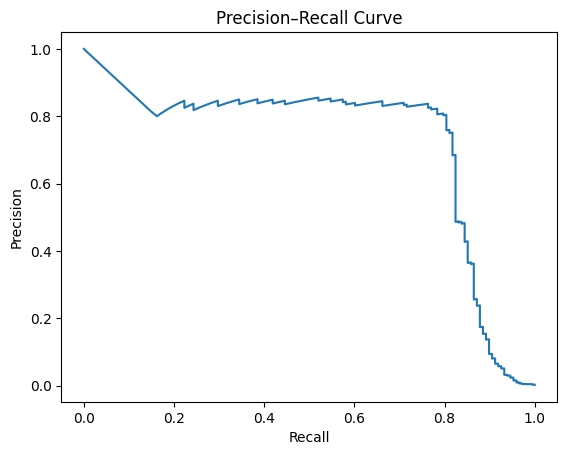

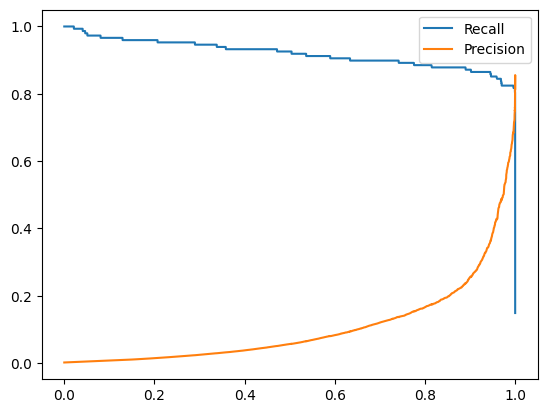

In [28]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_recall_curve
import matplotlib.pyplot as plt

X_train, X_test, y_train, y_test = train_test_split(
    Feat, Target,
    test_size=0.3,
    stratify=Target,
    random_state=404
)

P_test = model.predict_proba(X_test)[:, 1]

precision, recall, thresholds = precision_recall_curve(y_test, P_test)
plt.plot(recall, precision)
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision–Recall Curve")

plt.figure()
plt.plot(thresholds,recall[:-1])
plt.plot(thresholds,precision[:-1])
plt.legend(["Recall","Precision"])

Lowest cost threshold point given costs is: 0.7414725669444233  costing 3835.999999999999


Text(0, 0.5, 'Expected cost')

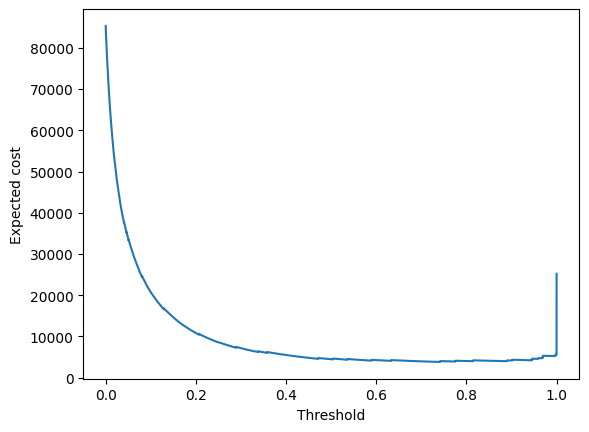

In [52]:
Fraud_cost = 200
FF_cost = 1  # False flag cost

N = len(P_test)  # sample size
Fraud_ratio = np.mean(y_test)  # assumes threshold 0 flags everything
Fraud_cases = int(np.sum(y_test).iloc[0])

Flags = recall / precision * Fraud_cases
Flags = np.where(np.isnan(Flags), 0, Flags)

Missed_frauds = (1 - recall) * Fraud_cases
FF = (1 - precision) * Flags

Cost = FF * FF_cost + Missed_frauds * Fraud_cost

print("Lowest cost threshold point given costs is:", thresholds[np.argmin(Cost)], " costing", np.min(Cost))

plt.plot(thresholds, Cost[:-1])
plt.xlabel("Threshold")
plt.ylabel("Expected cost")

Now we have a semi-functional pipeline. We can score new purchases utilizing the model, flag them if their fraud_likelyhood is above our threshold and hopefully save costs. 

In the long run we can monitor the performance as more "testing data" comes in, monitoring the actual cost compared with our expectations, and re-evaluate the model once new data has been acquired both for training and thresholds used. After all sneaky fraudulent people might attempt to change behavior once caught! 